# Theme 3 Supplement - Turbulent Mixing and Biophysical Interactions
## Plotting Satellite SST Data
OOI Data Labs Education Nuggets

_Written by Lori Garzio, Rutgers University_

_Disclaimer: data used in this example were accessed on Aug 18, 2020._

**Objective**: Demonstrate how to access Multi-scale Ultra-high Resolution (MUR) satellite Sea Surface Temperature data from the Mid-Atlantic Regional Association Coastal Ocean Observing System ([MARACOOS](https://maracoos.org/)) and make plots during Sept 2016 when extratropical storm Hermine passed over the Pioneer Array. 

These data were provided by JPL under support by NASA Making Earth Science Data Records for Use in Research Environments (MEaSUREs) program. This dataset is part of the Multi-sensor Improved Sea Surface Temperatures (MISST) project, which is part of the Group for High-Resolution Sea Surface Temperature (GHRSST) project.

In [1]:
# Notebook Setup
import datetime as dt
import xarray as xr
import numpy as np
import pandas as pd
import requests
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Data Access

The MARACOOS THREDDs server with archived SST data can be accessed [here](http://tds.maracoos.org/thredds/ARCHIVE-SST.html). For this example, we will be using the [MURSST Aggregation for 2016](http://tds.maracoos.org/thredds/ARCHIVE-SST.html?dataset=MURSST.2016.Agg). 

Once you've located the dataset, you can access the data using Python via the Data URL found in the OPENDAP link. You will also need to specify:

* the path to a local directory to which you want to save the plots
* the minimum and maximum latitude and longitudes you want to plot
* the date range you want to plot

In [2]:
# data url
sat_file = 'http://tds.maracoos.org/thredds/dodsC/MURSST/2016/Agg'

# save file directory - change this to a local directory
save_dir = '/Users/lgarzio/Documents/OOI/Nuggets/Theme3_satellite'

# define the coordinate limits to subset and plot
model_lims = dict(minlon=-73, maxlon=-69, minlat=38.5, maxlat=41.8)

# dates to plot
start_date = dt.datetime(2016, 9, 1)
end_date = dt.datetime(2016, 9, 10)

Open the 2016 aggregated satellite data file and subset the dataset for the time range you want to plot.

In [3]:
# open the dataset
ds = xr.open_dataset(sat_file, mask_and_scale=False)

# subset based on time
ds = ds.sel(time=slice(start_date, end_date + dt.timedelta(days=1)))

# print the dataset to see the dimensions, coordinates, variables, etc
ds

<xarray.Dataset>
Dimensions:           (lat: 3601, lon: 5001, time: 10)
Coordinates:
  * lon               (lon) float64 -100.0 -99.99 -99.98 ... -50.02 -50.01 -50.0
  * lat               (lat) float64 16.0 16.01 16.02 16.03 ... 51.98 51.99 52.0
  * time              (time) datetime64[ns] 2016-09-01T09:00:00 ... 2016-09-10T09:00:00
Data variables:
    sea_ice_fraction  (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    analysed_sst      (time, lat, lon) float32 ...
Attributes:
    Conventions:                ACDD-1.3, CF-1.6
    title:                      Daily MUR SST, Interim near-real-time (nrt) p...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    near real time (nrt) version created at nomin...
    comment:                    Interim-MUR(nrt) will be replaced by MUR-Fina...
   

In [4]:
# grab the time, latitude, and longitude variables
tm = ds['time']
lon = ds['lon']
lat = ds['lat']

In [5]:
# print the time variable
tm

<xarray.DataArray 'time' (time: 10)>
array(['2016-09-01T09:00:00.000000000', '2016-09-02T09:00:00.000000000',
       '2016-09-03T09:00:00.000000000', '2016-09-04T09:00:00.000000000',
       '2016-09-05T09:00:00.000000000', '2016-09-06T09:00:00.000000000',
       '2016-09-07T09:00:00.000000000', '2016-09-08T09:00:00.000000000',
       '2016-09-09T09:00:00.000000000', '2016-09-10T09:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-09-01T09:00:00 ... 2016-09-10T09:00:00
Attributes:
    long_name:      reference time of sst field
    standard_name:  time
    axis:           T
    comment:        Nominal time of analyzed fields

This dataset has one timestamp per day and covers the entire northwest Atlantic region. We want to subset the data to zoom in to the defined Pioneer Array region. In order to do that, we'll create indices where latitude and longitude are within our coordinates defined above, and select the SST data just within those coordinates. The SST variable is called 'analysed_sst'.

In [6]:
lon_ind = np.logical_and(lon > model_lims['minlon'], lon < model_lims['maxlon'])
lat_ind = np.logical_and(lat > model_lims['minlat'], lat < model_lims['maxlat'])

# grab the SST data within the defined coordinates
sst = np.squeeze(ds['analysed_sst'][:, lat_ind, lon_ind])
sst

<xarray.DataArray 'analysed_sst' (time: 10, lat: 330, lon: 399)>
[1316700 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -72.99 -72.98 -72.97 -72.96 ... -69.03 -69.02 -69.01
  * lat      (lat) float64 38.51 38.52 38.53 38.54 ... 41.77 41.78 41.79 41.8
  * time     (time) datetime64[ns] 2016-09-01T09:00:00 ... 2016-09-10T09:00:00
Attributes:
    units:          kelvin
    _FillValue:     -32768.0
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_temperature
    valid_min:      -32767
    valid_max:      32767
    comment:        Interim near-real-time (nrt) version using Multi-Resoluti...
    source:         AVHRR19_G-NAVO, AVHRR_METOP_A-EUMETSAT, MODIS_A-JPL, MODI...
    _ChunkSizes:    [   1 1201 1667]

Note the latitude and longitude dimensions went from lat: 3601, lon: 5001 to lat: 330, lon: 399, so we substantially subset the grid to make this dataset more manageable for plotting.

## Set up plot for one timestamp

Here is a function to plot the SST data, add map features to the plot, add the locations of the Pioneer moorings, and save the plot to a directory on your local machine (if the file path is provided).

In [7]:
def plot_sst(plt_ttl, clabel, lon_data, lat_data, data, array_loc, save_figname=None):
    """
    Create a pcolor surface map of SST
    plt_ttl: title for the plot
    clabel: label for the color bar
    lon_data: longitude data
    lat_data: latitude data
    data: variable data
    array_loc: data frame containing mooring coordinates
    save_figname: optional, full file path to save directory and save filename
    """
    # set up the map
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

    plt.subplots_adjust(right=0.88)  # adjust the right margin of the plot
    plt.title(plt_ttl, fontsize=15)  # add the title

    # format the spacing of the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size='5%', pad=0.1, axes_class=plt.Axes)
    fig.add_axes(cax)

    # plot the data
    h = ax.pcolor(lon_data, lat_data, data, vmin=18, vmax=26, cmap='jet')

    # add the color bar
    cb = plt.colorbar(h, cax=cax, extend='both')
    cb.set_label(label=clabel, fontsize=14)  # add the label on the colorbar
    cb.ax.tick_params(labelsize=12)  # format the size of the tick labels

    # add the latitude and longitude gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=.5, 
                      color='gray', alpha=0.5, linestyle='dotted')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}

    # add map features
    land = cfeature.NaturalEarthFeature('physical', 'land', '10m')
    ax.add_feature(land, edgecolor='black', facecolor='lightgray')

    state_lines = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

    ax.add_feature(cfeature.BORDERS, zorder=6)
    ax.add_feature(state_lines, zorder=7, edgecolor='black')
    
    # add the mooring locations, make the CP03ISSM mooring diamond black
    # for comparison with CP03ISSM METBK and CTD data from the data nugget
    for item, row in array_loc.iterrows():
        if item =='CP03ISSM':
            cc = 'black'
            ec = 'white'
            order = 2  # make sure it's plotted on top of the other markers
        else:
            cc = 'white'
            ec = 'black'
            order = 1
        ax.scatter(row.lon, row.lat, s=55, marker='d', color=cc, edgecolor=ec, 
                   zorder=order)

    # save the figure only if a figure path is provided
    if save_figname is not None:
        plt.savefig(save_figname, dpi=200)

Now, we will get the data for SST just at the first timestamp in our subset time array, get the locations of the Pioneer moorings, and pass all of the information needed to the plotting function.

In [8]:
# get the data for SST at the first timestamp in the time array
t = tm[0]  # grab the first timestamp
sst_t0 = sst.sel(time=t.values)

# convert fill values to NaNs
sst_t0.values[sst_t0 == -32768.0] = np.nan

varname = sst_t0.long_name
print(sst_t0)

<xarray.DataArray 'analysed_sst' (lat: 330, lon: 399)>
array([[27.339, 27.36 , 27.382, ..., 27.162, 27.179, 27.195],
       [27.343, 27.364, 27.385, ..., 27.171, 27.188, 27.204],
       [27.347, 27.368, 27.389, ..., 27.181, 27.197, 27.212],
       ...,
       [   nan,    nan,    nan, ..., 21.864, 21.869, 21.874],
       [   nan,    nan,    nan, ..., 21.912, 21.918, 21.923],
       [   nan,    nan,    nan, ..., 21.96 , 21.966, 21.972]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -72.99 -72.98 -72.97 -72.96 ... -69.03 -69.02 -69.01
  * lat      (lat) float64 38.51 38.52 38.53 38.54 ... 41.77 41.78 41.79 41.8
    time     datetime64[ns] 2016-09-01T09:00:00
Attributes:
    units:          kelvin
    _FillValue:     -32768.0
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_temperature
    valid_min:      -32767
    valid_max:      32767
    comment:        Interim near-real-time (nrt) version using Multi-Resoluti...
    source:         AVHRR19

Here is a function to return all of the locations of the moorings from an OOI array, using the [Rutgers OOI Data Review Database](https://datareview.marine.rutgers.edu/).

In [9]:
def return_array_subsites_standard_loc(array):
    DBurl= 'https://datareview.marine.rutgers.edu/regions/view/{}.json'.format(array)
    r = requests.get(DBurl)
    url_ct = r.json()['region']['sites']
    loc_df = pd.DataFrame()
    for ii in range(len(url_ct)):
        if url_ct[ii]['reference_designator'] != 'CP05MOAS':
            data = {
                    'lat': url_ct[ii]['latitude'],
                    'lon': url_ct[ii]['longitude'],
                    'max_z': url_ct[ii]['max_depth']
                    }
            new_r = pd.DataFrame(data, columns=['lat', 'lon', 'max_z'], 
                                 index=[url_ct[ii]['reference_designator']])
            loc_df = loc_df.append(new_r)
    return loc_df

In [10]:
array_location = return_array_subsites_standard_loc('CP')
print(array_location)

              lat      lon  max_z
CP01CNPM  40.1392 -70.7795     70
CP01CNSM  40.1334 -70.7785    133
CP01CNSP  40.1341 -70.7701    133
CP02PMCI  40.2267 -70.8782    127
CP02PMCO  40.0963 -70.8789    148
CP02PMUI  40.3649 -70.7700     95
CP02PMUO  39.9394 -70.7708    452
CP03ISPM  40.3647 -70.8882     70
CP03ISSM  40.3619 -70.8783     92
CP03ISSP  40.3672 -70.8818     92
CP04OSPM  39.9365 -70.8802    453
CP04OSSM  39.9371 -70.8870    450


Define information for the plot such as the label names.

In [11]:
# define labels for plot
# convert timestamp to string
timestr = dt.datetime.strftime(pd.to_datetime(t.values), '%d %b %Y')
print('Currently plotting: {}'.format(timestr))

# define plot title and color label title
title = '{}'.format(timestr)
color_label = 'SST ($^\circ$C)'

Currently plotting: 01 Sep 2016


## Generate plots

Finally, let's pass the information to the function to create a plot (which may take several minutes to create). This time, we won't pass the save file path (the last argument) to the function, so the plot will be displayed below but not saved to your local machine. After we confirm the plotting function works, we can write a loop to make more than one plot and save those plots to your local machine.

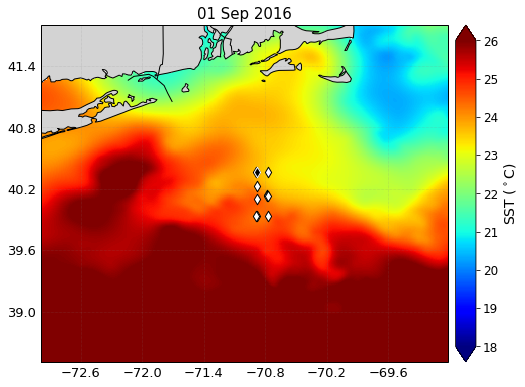

In [12]:
# pass the necessary information to the function to create the plot (without the save file path)
plot_sst(title, color_label, sst_t0.lon.values, sst_t0.lat.values, sst_t0.values, array_location)

Here is an image of Sea Surface Temperature for Sept 1, 2016, with the locations of the Pioneer array moorings indicated by the white diamonds and the Pioneer Inshore Surface Mooring (CP03ISSM) indicated by the black diamond. This is several days before extratropical storm Hermine passed over the region (Sept 5-6).

Now that we have verified that the plotting function works, let's generate plots for the entire time range to visualize how the SST changes as the storm passes. We will also save the images to your local machine - this will take several minutes to complete.

Currently plotting: 01 Sep 2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/Theme3_satellite/mur_sst_20160901.png
Currently plotting: 02 Sep 2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/Theme3_satellite/mur_sst_20160902.png
Currently plotting: 03 Sep 2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/Theme3_satellite/mur_sst_20160903.png
Currently plotting: 04 Sep 2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/Theme3_satellite/mur_sst_20160904.png
Currently plotting: 05 Sep 2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/Theme3_satellite/mur_sst_20160905.png
Currently plotting: 06 Sep 2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/Theme3_satellite/mur_sst_20160906.png
Currently plotting: 07 Sep 2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/Theme3_satellite/mur_sst_20160907.png
Currently plotting: 08 Sep 2016
save filepath: /Users/lgarzio/Documents/OOI/Nuggets/Theme3_satellite/mur_sst_20160908.png
Currently plotting: 09 S

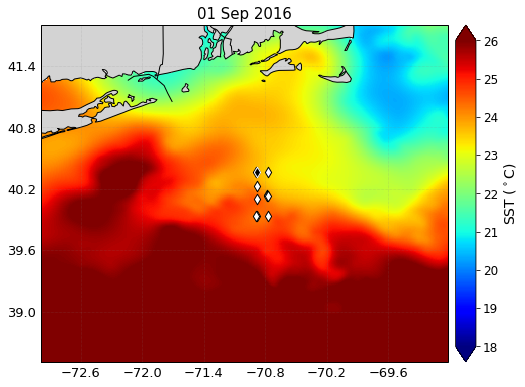

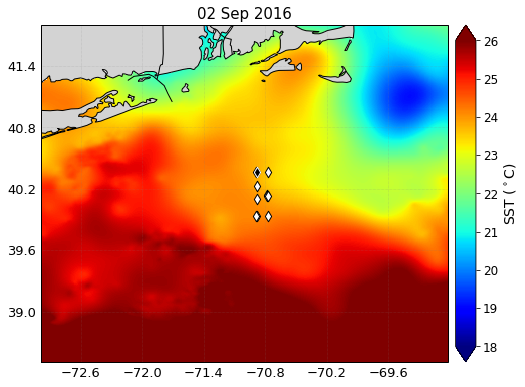

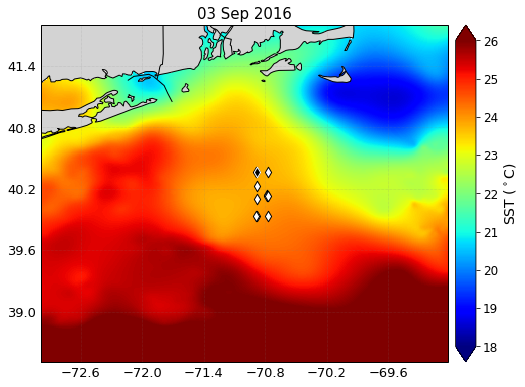

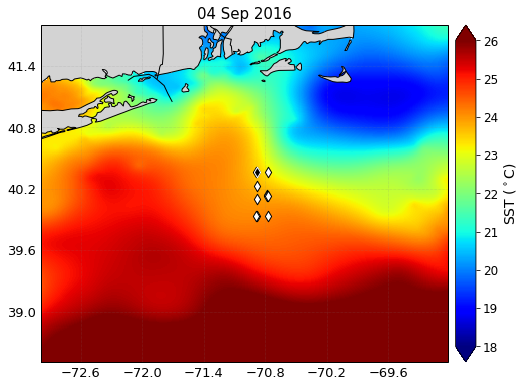

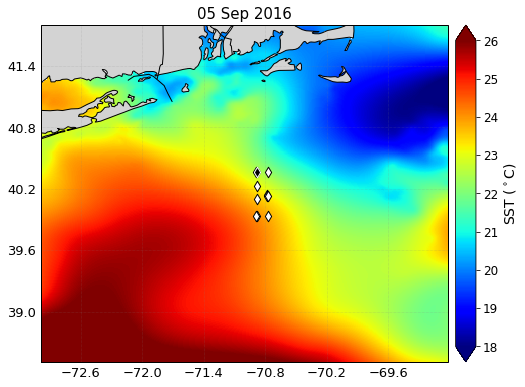

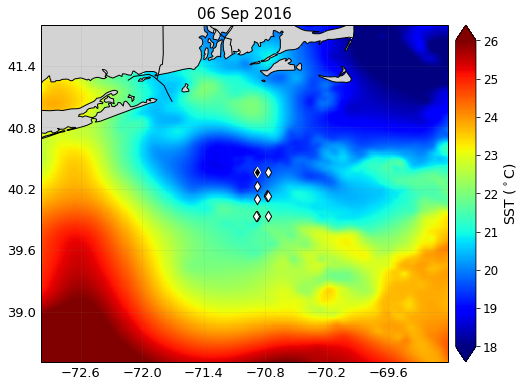

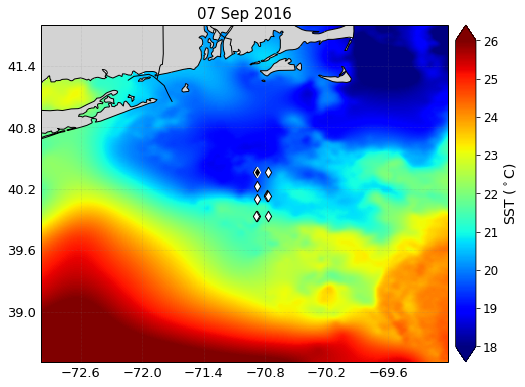

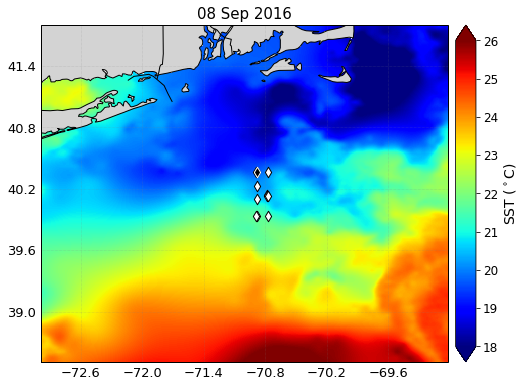

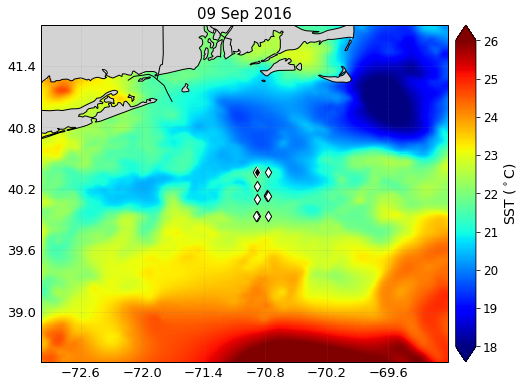

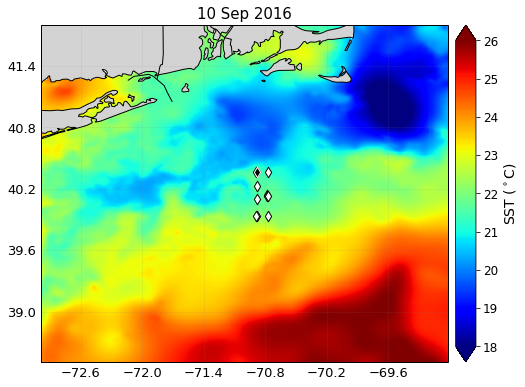

In [13]:
for t in tm:
    # get the SST data at the defined timestamp
    sst_tm = sst.sel(time=t.values)

    # convert fill values to NaNs
    sst_tm.values[sst_tm == -32768.0] = np.nan
    
    lons = sst_tm.lon.values
    lats = sst_tm.lat.values
    
    # define labels for plot
    # convert timestamp to string
    timestr = dt.datetime.strftime(pd.to_datetime(t.values), '%d %b %Y')
    print('Currently plotting: {}'.format(timestr))

    # define plot title and color label title
    title = '{}'.format(timestr)
    color_label = 'SST ($^\circ$C)'

    # create a full save file path for the image
    sdate = dt.datetime.strftime(pd.to_datetime(t.values), '%Y%m%d')
    figname = 'mur_sst_{}.png'.format(sdate)
    sfig = os.path.join(save_dir, figname)
    print('save filepath: {}'.format(sfig))
    
    # pass the necessary information to the function to create the plot, 
    # including the save file path to save plots to local machine
    plot_sst(title, color_label, lons, lats, sst_tm.values, array_location, sfig)

When scrolling through the images created for each day, you can see the substantial cooling of surface waters as the storm passes over the array!